In [1]:
# default_exp adversarial_experiment

In [1]:
# hide
%load_ext autoreload
%autoreload 2
from ipynb_path import *

In [2]:
# export
from optparse import Option
from counterfactual.training_module import BaseModule
from counterfactual.import_essentials import *
from counterfactual.train import train_model
from counterfactual.net import AdvCounterfactualModel, CounterfactualModel
from counterfactual.evaluate import cf_gen_parallel, model_cf_gen, load_trained_model
from counterfactual.interface import LocalExplainerBase
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

from torchmetrics.functional.classification import accuracy

In [7]:
Path("assets/weights/loan/1994").glob('*.ckpt').__next__()

Path('assets/weights/loan/1994/epoch=33-step=3263.ckpt')

## Move models to `assets/weights/`

In [22]:
for year in range(1994, 2010):
    model_path = [x for x in Path(f'../log/mse/linear/adv/loan/year={year}/version_0/checkpoints/').iterdir()][-1]
    Path(f"assets/weights/loan/{year}").mkdir()
    shutil.copy(model_path, Path(f"assets/weights/loan/{year}"))

## Dummy Data

In [40]:
X_1 = pd.DataFrame({
    'x1': np.random.normal(-2, 0.5, 1000),
    'x2': np.random.normal(-2, 0.5, 1000),
    'y': np.ones((1000,))
})

X_0 = pd.DataFrame({
    'x1': np.random.normal(2, 0.7, 1000),
    'x2': np.random.normal(2, 0.7, 1000),
    'y': np.zeros((1000,))
})
X = pd.concat((X_0, X_1))
X = shuffle(X)
X.to_csv('assets/data/adv/dummy/orig.csv', index=False)

In [41]:
X_1_update = pd.DataFrame({
    'x1': np.random.normal(-2, 1, 1000),
    'x2': np.random.normal(0, 1, 1000),
    'y': np.ones((1000,))
})

X_0_update = pd.DataFrame({
    'x1': np.random.normal(2, 0.7, 1000),
    'x2': np.random.normal(2, 0.7, 1000),
    'y': np.zeros((1000,))
})
X_update = pd.concat((X_0_update, X_1_update))
X_update = shuffle(X_update)
X_update.to_csv('assets/data/adv/dummy/update.csv', index=False)

Text(0.5, 1.0, 'original')

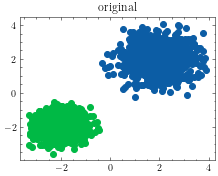

In [9]:
plt.scatter(X_0['x1'], X_0['x2'], cmap='Paired')
plt.scatter(X_1['x1'], X_1['x2'], cmap='Paired')
plt.title('original')

Text(0.5, 1.0, 'update')

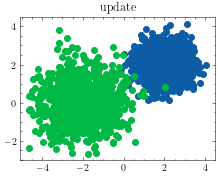

In [10]:
plt.scatter(X_0_update['x1'], X_0_update['x2'], cmap='Paired')
plt.scatter(X_1_update['x1'], X_1_update['x2'], cmap='Paired')
plt.title('update')

## Experiment

In [3]:
# export
def adv_validity(m1: CounterfactualModel, m2: CounterfactualModel, x_1: torch.Tensor, cf_1: torch.Tensor):
    """check validity of the updated model

    Args:
        m1 (BaseModule): original model
        m2 (BaseModule): updated model

    Returns:
        [float]: return validity score of m1's CF on m2
    """
    y_prime = torch.ones(len(x_1)) - m1.predict(x_1)
    # cf_y_1 = m1.predict(cf)
    cf_y_2 = m2.predict(cf_1)

    # val_1 = accuracy(y_prime, cf_y_1.int())
    val_2 = accuracy(y_prime, cf_y_2.int())

    # print(f"val_1: {val_1}, val_2: {val_2}")
    return val_2.item()

In [4]:
# export
def avg_decrease(matrix: np.ndarray):
    if not isinstance(matrix, (list, np.ndarray)):
        raise ValueError(f"`matrix` needs to be a list or numpy array, but got {type(matrix)}.")
    result = {}
    n_datasets = len(matrix[0])

    validity = [matrix[i][i] for i in range(n_datasets)]
    result.update({
        'cf_validity': {
            'avg': np.average(validity), 'std': np.std(validity)
        }
    })

    w1_result = []
    for i in range(n_datasets - 1):
        w1_result += [matrix[i][i] - matrix[i][i+1]]
    result.update({
        'w=1': {
            'avg': np.average(w1_result), 'std': np.std(w1_result)
        }
    })

    wall_result =  []
    for i in range(n_datasets):
        for j in range(n_datasets):
            if j == i:
                continue
            wall_result += [matrix[i][i] - matrix[i][j]]
    result.update({
        'all': {
            'avg': np.average(wall_result), 'std': np.std(wall_result)
        }
    })

    for k in result.keys():
        print(f"[{k}] avg={result[k]['avg']:.4f}; std={result[k]['std']:.4f}")
    return result

In [10]:
# export
def avg_validity_changes(matrix: np.ndarray):
    if not isinstance(matrix, (list, np.ndarray)):
        raise ValueError(f"`matrix` needs to be a list or numpy array, but got {type(matrix)}.")
    result = {}
    n_datasets = len(matrix[0])

    validity = [matrix[i][i] for i in range(n_datasets)]

    w1_val_result, w1_dec_result = [], []
    for i in range(n_datasets - 1):
        w1_val_result.append(matrix[i][i+1])
        w1_dec_result.append(matrix[i][i] - matrix[i][i+1])

    wall_val_result, wall_dec_result =  [], []
    for i in range(n_datasets):
        for j in range(n_datasets):
            if j == i: continue
            wall_val_result.append(matrix[i][j])
            wall_dec_result.append(matrix[i][i] - matrix[i][j])
    result = {
        'cf_validity': { 'mean': np.average(validity), 'std': np.std(validity) },
        'cf_validity (w=1)': { 'mean': np.average(w1_val_result), 'std': np.std(w1_val_result) },
        'cf_validity (all)': { 'mean': np.average(wall_val_result), 'std': np.std(wall_val_result) },
        'validity_decrease (w=1)': { 'mean': np.average(w1_dec_result), 'std': np.std(w1_dec_result) },
        'validity_decrease (all)': { 'mean': np.average(wall_dec_result), 'std': np.std(wall_dec_result) }
    }

    return pd.DataFrame.from_dict(result)

In [6]:
# export
def _useful_result(result: Dict[str, Any]) -> Dict[str, Any]:
    # average_time,pred_accuracy,validity,proximity
    useful_metrics = ["average_time", "pred_accuracy", "validity", "proximity"]
    useful_results = {metric: result[metric] for metric in useful_metrics}
    # result.pop('x', None); result.pop('cf', None)
    # result.pop('y_prime', None); result.pop('cf_y', None)
    return useful_results


def _logger_name(data_dir: str) -> str:
    return data_dir.split("assets/data/")[1].split(".csv")[0]

In [ ]:
# export
def _aggregate_default_data_encoders(default_model_config: Dict[str, Any], data_dir_list: List[str]):
    # data encoding
    data = pd.concat(
        [pd.read_csv(data_dir) for data_dir in data_dir_list]
    )
    pl_logger.info(f"total data length: {len(data)}")
    if len(default_model_config['continous_cols']) != 0:
        pl_logger.info("preprocessing continuous features...")
        normalizer = MinMaxScaler().fit(
            data[default_model_config['continous_cols']]
        )
        default_model_config.update({"normalizer": normalizer})

    if len(default_model_config['discret_cols']) != 0:
        pl_logger.info("preprocessing discret features...")
        encoder = OneHotEncoder(sparse=False).fit(
            data[default_model_config['discret_cols']]
        )
        default_model_config.update({"encoder": encoder})
    return default_model_config


def _set_val_model_dict(val_models: List[Any], index: int, length: int):
    w_1_models = list()
    if index > 0:
        w_1_models.append(val_models[index - 1])
    if index < length - 1:
        w_1_models.append(val_models[index + 1])

    w_all_models = deepcopy(val_models)
    w_all_models.pop(index)
    return { "w=1": w_1_models, "w=all": w_all_models}


def _train_models(
    default_model_config: Dict[str, Any],
    t_config: Dict[str, Any],
    data_dir_list: List[str],
    module: CounterfactualModel,
    use_prev_model_weights: bool = False,
    return_best_model: bool = False, # return last model by default
    tb_logger_dir: Optional[str] = "",
    save_models_to_assets: bool = False
) -> List[str]:
    model_list = []
    model_checkpoints_list = []
    last_model_path = None

    for i, data_dir in enumerate(data_dir_list):
        model_config = deepcopy(default_model_config)
        model_config['data_dir'] = data_dir
        if 'adv_val_models' not in model_config.keys():
            model_config['adv_val_models'] = None
        if model_config['adv_val_models']: # not None
            model_config['adv_val_models'] = _set_val_model_dict(model_config['adv_val_models'], i, len(data_dir_list))

        if not use_prev_model_weights:
            # train model from scratch
            training_results = train_model(
                module(model_config),
                t_config, logger_name=f"{tb_logger_dir}{_logger_name(data_dir)}",
                return_best_model_path=True
            )
        else:
            # use last trained model as the init weight
            last_model = module(model_config).load_from_checkpoint(last_model_path, **model_config)
            training_results = train_model(
                last_model,
                t_config, logger_name=f"{_logger_name(data_dir)}",
                return_best_model_path=True
            )
        last_model_path = training_results['best_model_path']
        _model = training_results['model']
        if return_best_model:
            _model.load_from_checkpoint(last_model_path)
            if save_models_to_assets:
                shutil.copy(last_model_path, f'assets/weights/')

        model_list.append(_model)
        # best_model = module(model_config).load_from_checkpoint(last_model_path, **model_config)
        model_checkpoints_list.append(last_model_path)

    assert len(model_checkpoints_list) == len(data_dir_list)
    # return model_checkpoints_list
    return model_list


def _calculate_validity_matrix(model_list: List[BaseModule], cf_results: Dict[str, Any]):
    validity_matrix = []
    n_models = len(model_list)
    for i in range(n_models):
        result_i = []
        for j in range(n_models):
            _cf_result = cf_results[f"m_{i}"]
            val = adv_validity(model_list[i], model_list[j], x_1=_cf_result['x'], cf_1=_cf_result['cf'])
            result_i.append(val)
        validity_matrix.append(result_i)
    return validity_matrix


def _store_results(results: Dict[str, Any]) -> None:
    data_name = results['data_name']
    cf_results = results['cf_results']
    validity_matrix = results['validity_matrix']
    model_list = results['model_list']
    hparam = results['hparams']
    # create default directory
    if not Path(f'assets/result/{data_name}').exists():
        Path(f'assets/result/{data_name}').mkdir()

    # create logging directory
    experiment_versions = []
    adv = results['adv']
    for p in Path(f'assets/result/{data_name}').iterdir():
        _adv, _, n_version = p.name.split('_')
        if _adv == 'adv=True' and adv:
            experiment_versions.append(int(n_version))
        if (_adv == 'adv=False') and (not adv):
            experiment_versions.append(int(n_version))

    sorted_experiment_versions = sorted(experiment_versions)
    if len(sorted_experiment_versions) == 0:
        sorted_experiment_versions = [-1]
    n_version = sorted_experiment_versions[-1] + 1

    dir_path = Path(f'assets/result/{data_name}/adv={adv}_version_{n_version}')
    dir_path.mkdir(exist_ok=False)

    # store hparam
    with open(dir_path / 'hparam.yml', 'w') as f:
        yaml.dump(hparam, f, default_flow_style=False)

    # store validity matrix
    col_names = [f'm_{i}' for i in range(len(model_list))]
    pd.DataFrame(validity_matrix, columns=col_names, index=col_names).to_csv(dir_path / 'validity_matrix.csv')

    # store cf results (e.g., proximity)
    pd.DataFrame.from_dict(cf_results, orient='index').to_csv(dir_path / 'metrics.csv')
    return dir_path

### Experiment Logger

In [ ]:
# export
class ExperimentLogger(ABC):
    def store_results(self, results: Dict[str, Any]) -> None:
        raise NotImplementedError

class ExperimentLoggerLocal(ExperimentLogger):
    def __init__(self) -> None:
        pass

    def _create_logging_dir(self, dataset_path: Path, adv_training: bool) -> Path:
        # find experiment version
        experiment_versions = []
        for p in dataset_path.iterdir():
            _adv, _, n_version = p.name.split('_')
            if _adv == 'adv=True' and adv_training:
                experiment_versions.append(int(n_version))
            if (_adv == 'adv=False') and (not adv_training):
                experiment_versions.append(int(n_version))

        sorted_experiment_versions = sorted(experiment_versions)
        if len(sorted_experiment_versions) == 0:
            sorted_experiment_versions = [-1]
        n_version = sorted_experiment_versions[-1] + 1

        # create new dir
        dir_path = dataset_path / Path(f"adv={adv_training}_version_{n_version}")
        dir_path.mkdir(exist_ok=False)
        return dir_path

    def store_results(self, results: Dict[str, Any]) -> None:
        data_name = results['data_name']
        cf_results = results['cf_results']
        validity_matrix = results['validity_matrix']
        model_list = results['model_list']
        hparam = results['hparams']
        dataset_path = Path(f'assets/result/{data_name}')

        # create default directory
        if not dataset_path.exists():
            dataset_path.mkdir()

        # create logging directory
        adv = results['adv']
        dir_path = self._create_logging_dir(dataset_path=dataset_path, adv_training=adv)

        # store hparam
        with open(dir_path / 'hparam.yml', 'w') as f:
            yaml.dump(hparam, f, default_flow_style=False)

        # store validity matrix
        col_names = [f'm_{i}' for i in range(len(model_list))]
        pd.DataFrame(validity_matrix, columns=col_names, index=col_names).to_csv(dir_path / 'validity_matrix.csv')

        # store cf results (e.g., proximity)
        cf_results = {m: _useful_result(cf_results[m]) for m in col_names }
        pd.DataFrame.from_dict(cf_results, orient='index').to_csv(dir_path / 'metrics.csv')
        return dir_path

In [ ]:
# export
class ExperimentLoggerWanb(ExperimentLogger):
    def __init__(self, logger_name: str) -> None:
        super().__init__()
        # self.logger_name = logger_name
        self.run = wandb.init(project="adv-counternet", entity="birkhoffg", name=logger_name, settings=wandb.Settings(start_method="fork"))

    def store_results(self, results: Dict[str, Any]) -> None:
        data_name = results['data_name']
        cf_results = results['cf_results']
        validity_matrix = results['validity_matrix']
        model_list = results['model_list']
        hparam = results['hparams']
        t_config = results['trainer_configs']

        # with wandb.init(project="my-test-project", entity="birkhoffg", name=self.logger_name, settings=wandb.Settings(start_method="fork")) as run:
        with self.run as run:
            # store hparam
            run.config.update(hparam)
            run.config.update(t_config)

            # store cf results (e.g., proximity)
            col_names = [f'm_{i}' for i in range(len(model_list))]
            cf_results = {m: _useful_result(cf_results[m]) for m in col_names }
            cf_results_df = pd.DataFrame.from_dict(cf_results, orient='index')
            # cf metric stats
            cf_aggre_df = cf_results_df.describe().loc[['mean', 'std']].reset_index().rename(columns={'index': 'stat'})
            cf_results_df = cf_results_df.reset_index().rename(columns={'index': 'model_name'})
            cf_results_table = wandb.Table(dataframe=cf_results_df)
            cf_aggre_table = wandb.Table(dataframe=cf_aggre_df)

            # store validity matrix
            val_matrix_df = pd.DataFrame(validity_matrix, columns=col_names, index=col_names)
            val_matrix_df = val_matrix_df.reset_index().rename(columns={'index': 'model_name'})
            val_matrix_table = wandb.Table(dataframe=val_matrix_df)
            val_matrix_heatmap = wandb.plots.HeatMap(x_labels=col_names, y_labels=col_names, matrix_values=validity_matrix, show_text=False)

            # avg validity changes
            avg_val_changes_df = avg_validity_changes(validity_matrix).reset_index().rename(columns={'index': 'stat'})
            avg_val_changes_table = wandb.Table(dataframe=avg_val_changes_df)

            run.log({
                'Validity Matrix': val_matrix_table, 'Heatmap': val_matrix_heatmap,
                'CF Results': cf_results_table, 'Validity Changes': avg_val_changes_table,
                'CF Metrics': cf_aggre_table
            })
        return self.run.dir

        # self.run.finish()

### Experiment function

In [7]:
# export
def experiment_step(
    default_model_config: Dict[str, Any],
    t_config: Dict[str, Any],
    data_dir_list: List[str],
    module: CounterfactualModel,
    use_prev_model_weights: bool = False,
    return_best_model: bool = False, # return last model by default
    tb_logger_dir: Optional[str] = "",
    save_models_to_assets: bool = False,
    experiment_logger: Optional[ExperimentLogger] = None
) -> Dict[str, Any]:
    """set up experiment for CounterNet on distributional shifted datasets

    Args:
        default_model_config (Dict[str, Any]): model configuration for CounterNet
        t_config (Dict[str, Any]): training configuration
        data_dir_list (List[str]): a list of dataset paths (e.g., `["w_1.csv", "w_2.csv"]`);
            the length of `data_dir_list` should be equal to the length of returned `model_list`
        module (CounterfactualModel): CounterfactualModel to be trained
        use_prev_model_weights (bool, optional): define whether to use the previously trained model
            as a starting point (True) or not (False). Defaults to False.
        return_best_model (bool, optional): return the best model (according to the validation set, True)
            or the model trained in the last epoch (False). Defaults to False.

    Returns:
        Dict[str, Any]: the result of the experiment
            * `hparams`: hyperparameters for training the model
            * `cf_results`: a list of cf results (e.g., validity, proximity) on the original datasets for each model
            * `validity_matrix`: the validity matrix of each CounterNet models on all other models
            * `model_list`: the list of CounterNet model
    """
    hparams = deepcopy(default_model_config)
    hparams.update(t_config)
    # data encoding
    pl_logger.info("aggregating data...")
    default_model_config = _aggregate_default_data_encoders(default_model_config, data_dir_list)

    # trained model
    pl_logger.info("start training...")
    model_list = _train_models(default_model_config, t_config,
        data_dir_list, module, use_prev_model_weights, return_best_model, tb_logger_dir)

    # extract models from `model_checkpoints_list`
    pl_logger.info("extracting useful cf results...")
    # _model_config = deepcopy(default_model_config)
    # model_list = [
    #     module(_model_config).load_from_checkpoint(checkpoint_path, **_model_config)
    #         for checkpoint_path in model_checkpoints_list
    # ]

    cf_results = {}
    for i, m in enumerate(model_list):
        cf_results[f'm_{i}'] = model_cf_gen(m) #_useful_result(model_cf_gen(m))

    # calculate the validity matrix
    pl_logger.info("calculating validity matrix...")
    validity_matrix = _calculate_validity_matrix(model_list, cf_results)

    # store result
    results = {
        'adv': default_model_config['adv'],
        'data_name': default_model_config['data_name'],
        'hparams': hparams,
        'trainer_configs': t_config,
        'cf_results': cf_results,
        'validity_matrix': validity_matrix,
        'model_list': model_list,
        # 'result_path': path
    }
    if experiment_logger is not None:
        dir_path = experiment_logger.store_results(results)
        print(f"Results stored at {dir_path}.")
        # _store_results(results)

    return results

In [ ]:
# export
def local_explainer_experiment_step(default_model_config: Dict[str, Any],
                                    t_config: Dict[str, Any],
                                    data_dir_list: List[str],
                                    pred_module: BaseModule,
                                    cf_params: Dict[str, Any],
                                    cf_module: LocalExplainerBase,
                                    is_parallel: bool = True,
                                    test_size: Optional[int] = None,
                                    use_prev_model_weights: bool = False,
                                    return_best_model: bool = False, # return last model by default
                                    experiment_logger: Optional[ExperimentLogger] = None) -> Dict[str, Any]:

    hparams = deepcopy(default_model_config)
    # data encoding
    pl_logger.info("aggregating data...")
    default_model_config = _aggregate_default_data_encoders(default_model_config, data_dir_list)

    # trained model
    pl_logger.info("start training...")
    model_list = _train_models(default_model_config, t_config,
        data_dir_list, pred_module, use_prev_model_weights, return_best_model)

    # extract models from `model_checkpoints_list`
    pl_logger.info("extracting useful cf results...")

    cf_results = {}
    for i, m in enumerate(model_list):
        print(data_dir_list[i])
        cf_params.update({'model': m})
        _cf_result = cf_gen_parallel(cf_params, cf_module,is_parallel, test_size)
        # _cf_result = model_cf_gen(m)
        cf_results[f'm_{i}'] = _cf_result

    # calculate the validity matrix
    pl_logger.info("calculating validity matrix...")
    # validity_matrix = _calculate_validity_matrix(model_list)
    validity_matrix = _calculate_validity_matrix(model_list, cf_results)

    # store result
    results = {
        'adv': default_model_config['adv'],
        'data_name': default_model_config['data_name'],
        'hparams': hparams,
        'trainer_configs': {},
        'cf_results': cf_results,
        'validity_matrix': validity_matrix,
        'model_list': model_list,
        # 'result_path': path
    }
    if experiment_logger:
        dir_path = experiment_logger.store_results(results)
        print(f"Results stored at {dir_path}.")

    return results

In [8]:
# export utils
def l_inf_proj(delta: torch.Tensor, eps: float, cat_idx: Optional[int]=None):
    if cat_idx is None:
        return delta.clamp(-eps, eps)
    else:
        delta[:, :cat_idx] = delta[:, :cat_idx].clamp(-eps, eps)
        return delta

def l2_proj(delta: torch.Tensor, eps: float, cat_idx: Optional[int]=None):
    if cat_idx is None:
        return delta.renorm(p=2, dim=0, maxnorm=eps)
    else:
        delta[:, :cat_idx] = delta[:, :cat_idx].renorm(p=2, dim=0, maxnorm=eps)
        return delta

## Model

In [8]:
default_config = {
    "data_name": "dummy",
    "lr": 0.003,
    "batch_size": 128,
    "lambda_1": 1.0,
    "lambda_2": 0.01,
    "lambda_3": 0.2,
    "threshold": 1.0,
    "continous_cols": [
        "x1",
        "x2",
    ],
    "discret_cols": [],
    "encoder_dims": [
        2,
        100,
        10
    ],
    "decoder_dims": [
        10,
        10
    ],
    "explainer_dims": [
        10,
        10
    ],
    "loss_1": "mse",
    "loss_2": "mse",
    "loss_3": "mse",
    "adv": False
}


In [9]:
t_config = {
    "max_epochs": 150,
    "gpus": 1,
    "deterministic": True,
    "log_every_n_steps": 1,
    "automatic_optimization": False
}

In [10]:
data_dir_list = ["assets/data/adv/dummy/orig.csv", "assets/data/adv/dummy/update.csv"]

In [10]:
adv_false = experiment_step(
    default_config, t_config, data_dir_list
)

total data length: 4000
preprocessing continuous features...
start training...
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Disable automatic optimization with the trainer flag is deprecated and will be removed in v1.3.0!Please use the property on the LightningModule for disabling automatic optimization
  warnings.warn(*args, **kwargs)
hyper parameters: "adv":            False
"batch_size":     128
"continous_cols": ['x1', 'x2']
"data_dir":       assets/data/adv/dummy/orig.csv
"data_name":      dummy
"decoder_dims":   [10, 10]
"discret_cols":   []
"encoder_dims":   [2, 100, 10]
"explainer_dims": [10, 10]
"lambda_1":       1.0
"lambda_2":       0.01
"lambda_3":       0.2
"loss_1":         mse
"loss_2":         mse
"loss_3":         mse
"lr":             0.003
"normalizer":     MinMaxScaler()
"threshold":      1.0
x_cont: 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Disable automatic optimization with the trainer flag is deprecated and will be removed in v1.3.0!Please use the property on the LightningModule for disabling automatic optimization
  warnings.warn(*args, **kwargs)
hyper parameters: "adv":            False
"batch_size":     128
"continous_cols": ['x1', 'x2']
"data_dir":       assets/data/adv/dummy/update.csv
"data_name":      dummy
"decoder_dims":   [10, 10]
"discret_cols":   []
"encoder_dims":   [2, 100, 10]
"explainer_dims": [10, 10]
"lambda_1":       1.0
"lambda_2":       0.01
"lambda_3":       0.2
"loss_1":         mse
"loss_2":         mse
"loss_3":         mse
"lr":             0.003
"normalizer":     MinMaxScaler()
"threshold":      1.0
x_cont: (2000, 2), x_cat: (2000, 0)
(2000, 2)

  | Name          | Type              

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [11]:
default_config['adv'] = True
adv_true = experiment_step(
    default_config, t_config, data_dir_list
)

total data length: 4000
preprocessing continuous features...
start training...
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Disable automatic optimization with the trainer flag is deprecated and will be removed in v1.3.0!Please use the property on the LightningModule for disabling automatic optimization
  warnings.warn(*args, **kwargs)
hyper parameters: "adv":            True
"batch_size":     128
"continous_cols": ['x1', 'x2']
"data_dir":       assets/data/adv/dummy/orig.csv
"data_name":      dummy
"decoder_dims":   [10, 10]
"discret_cols":   []
"encoder_dims":   [2, 100, 10]
"explainer_dims": [10, 10]
"lambda_1":       1.0
"lambda_2":       0.01
"lambda_3":       0.2
"loss_1":         mse
"loss_2":         mse
"loss_3":         mse
"lr":             0.003
"normalizer":     MinMaxScaler()
"threshold":      1.0
x_cont: (

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Disable automatic optimization with the trainer flag is deprecated and will be removed in v1.3.0!Please use the property on the LightningModule for disabling automatic optimization
  warnings.warn(*args, **kwargs)
hyper parameters: "adv":            True
"batch_size":     128
"continous_cols": ['x1', 'x2']
"data_dir":       assets/data/adv/dummy/update.csv
"data_name":      dummy
"decoder_dims":   [10, 10]
"discret_cols":   []
"encoder_dims":   [2, 100, 10]
"explainer_dims": [10, 10]
"lambda_1":       1.0
"lambda_2":       0.01
"lambda_3":       0.2
"loss_1":         mse
"loss_2":         mse
"loss_3":         mse
"lr":             0.003
"normalizer":     MinMaxScaler()
"threshold":      1.0
x_cont: (2000, 2), x_cat: (2000, 0)
(2000, 2)

  | Name          | Type               

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [12]:
adv_false['cf_result']

{'w_0': {'diffs': 1,
  'total_num': 285,
  'robustness': 0.9964912533760071,
  'total_time': 0.0017230510711669922,
  'average_time': -1,
  'pred_accuracy': 1.0,
  'validity': 1.0,
  'proximity': 0.508935809135437},
 'w_1': {'diffs': 6,
  'total_num': 108,
  'robustness': 0.9444444179534912,
  'total_time': 0.0008447170257568359,
  'average_time': -1,
  'pred_accuracy': 0.9860000014305115,
  'validity': 1.0,
  'proximity': 0.5940748453140259}}

In [13]:
adv_false['validity_matrix']

[[1.0, 0.5339999794960022], [0.49000000953674316, 1.0]]

In [14]:
adv_true['cf_result']

{'w_0': {'diffs': 2,
  'total_num': 392,
  'robustness': 0.9948979616165161,
  'total_time': 0.0014259815216064453,
  'average_time': -1,
  'pred_accuracy': 1.0,
  'validity': 1.0,
  'proximity': 0.43749621510505676},
 'w_1': {'diffs': 24,
  'total_num': 216,
  'robustness': 0.8888888955116272,
  'total_time': 0.0008757114410400391,
  'average_time': -1,
  'pred_accuracy': 0.9900000095367432,
  'validity': 1.0,
  'proximity': 0.4717850685119629}}

In [15]:
adv_true['validity_matrix']

[[1.0, 0.1459999978542328], [0.49399998784065247, 1.0]]

In [11]:
default_config['data_dir'] = "assets/data/adv/dummy/orig.csv"
model_org = load_trained_model(
    CounterfactualModel(default_config), 
    checkpoint_path="../log/adv/dummy/orig/version_0/checkpoints/epoch=24-step=299.ckpt",
)

GPU available: True, used: False
TPU available: None, using: 0 TPU cores
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)
x_cont: (2000, 2), x_cat: (2000, 0)
(2000, 2)

  | Name          | Type                 | Params | In sizes | Out sizes
------------------------------------------------------------------------------
0 | encoder_model | MultilayerPerception | 1.3 K  | [1, 2]   | [1, 10]  
1 | predictor     | MultilayerPerception | 110    | [1, 10]  | [1, 10]  
2 | pred_linear   | Linear               | 11     | [1, 10]  | [1, 1]   
3 | explainer     | Sequential           | 232    | [1, 20]  | [1, 2]   
------------------------------------------------------------------------------
1.7 K     Trainable params
0         Non-trainable params
1.7 K     Total params
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/dist

Training: 0it [00:00, ?it/s]

In [12]:
default_config['data_dir'] = "assets/data/adv/dummy/update.csv"
model_upt = load_trained_model(
    CounterfactualModel(default_config), 
    checkpoint_path="../log/adv/dummy/update/version_0/checkpoints/epoch=16-step=203.ckpt",
)

GPU available: True, used: False
TPU available: None, using: 0 TPU cores
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)
x_cont: (2000, 2), x_cat: (2000, 0)
(2000, 2)

  | Name          | Type                 | Params | In sizes | Out sizes
------------------------------------------------------------------------------
0 | encoder_model | MultilayerPerception | 1.3 K  | [1, 2]   | [1, 10]  
1 | predictor     | MultilayerPerception | 110    | [1, 10]  | [1, 10]  
2 | pred_linear   | Linear               | 11     | [1, 10]  | [1, 1]   
3 | explainer     | Sequential           | 232    | [1, 20]  | [1, 2]   
------------------------------------------------------------------------------
1.7 K     Trainable params
0         Non-trainable params
1.7 K     Total params
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/dist

Training: 0it [00:00, ?it/s]

## Analysis

### Plot boundary

In [3]:

def plot_boundary(m):
    m.freeze()
    x, y = m.val_dataset[:]
    # Plotting decision regions
    x_min, x_max = x[:, 0].min() - 0.1, x[:, 0].max() + 0.1
    y_min, y_max = x[:, 1].min() - 0.1, x[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                        np.arange(y_min, y_max, 0.01))

    zz = m.predict(torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float())
    zz = zz.reshape(xx.shape)
    plt.contourf(xx, yy, zz, cmap='Paired')

    # create scatter of these samples
    x0 = x[y == 0.]
    x1 = x[y == 1.]
    plt.scatter(x0[:, 0], x0[:, 1], cmap='Paired')
    plt.scatter(x1[:, 0], x1[:, 1], cmap='Paired')


In [4]:

def plot_cf_boundary(m: CounterfactualModel):
    m.freeze()
    x, y = m.val_dataset[:]
    # Plotting decision regions
    x_min, x_max = x[:, 0].min() - 0.1, x[:, 0].max() + 0.1
    y_min, y_max = x[:, 1].min() - 0.1, x[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                        np.arange(y_min, y_max, 0.01))

    zz = m.predict(torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float())
    zz = zz.reshape(xx.shape)
    plt.contourf(xx, yy, zz, cmap='Paired')

    # create scatter of these samples
    cf = m.generate_cf(x)
    cf_y = m.predict(cf)
    cf_1 = cf[cf_y==0.]
    cf_0 = cf[cf_y==1.]
    plt.scatter(cf_0[:, 0], cf_0[:, 1], cmap='Paired')
    plt.scatter(cf_1[:, 0], cf_1[:, 1], cmap='Paired')



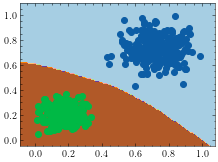

In [15]:
plot_boundary(model_org)

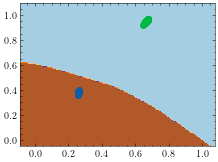

In [16]:
plot_cf_boundary(model_org)

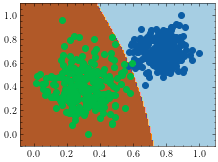

In [17]:
plot_boundary(model_upt)

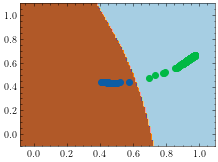

In [18]:
plot_cf_boundary(model_upt)

### Loan results

In [3]:
from counterfactual.adversarial_experiment import avg_decrease

In [6]:
print_metric = lambda x: x.set_axis(list(range(1994, 2010)))[['pred_accuracy','validity','proximity']]

In [7]:
roar_res = pd.read_csv("assets/result/loan/adv=True_version_11/validity_matrix.csv", index_col=0)
roar_res_metric = pd.read_csv("assets/result/loan/adv=True_version_11/metrics.csv", index_col=0)


In [11]:
avg_validity_changes(roar_res.to_numpy())

,cf_validity,cf_validity (w=1),cf_validity (all),validity_decrease (w=1),validity_decrease (all)
avg,0.995586,0.918884,0.866950,0.077086,0.128636
std,0.002902,0.198192,0.197215,0.199059,0.197023


In [21]:
avg_decrease(roar_res.to_numpy())
print_metric(roar_res_metric).describe().loc[['mean', 'std']]

[cf_validity] avg=0.9956; std=0.0029
[w=1] avg=0.0771; std=0.1991
[all] avg=0.1286; std=0.1970


,pred_accuracy,validity,proximity
mean,0.883434,0.995727,7.231803
std,0.035778,0.003024,0.795317


In [89]:
no_adv_res = pd.read_csv("assets/result/loan/adv=False_version_2/validity_matrix.csv", index_col=0)
adv_eps_001 = pd.read_csv("assets/result/loan/adv=True_version_4/validity_matrix.csv", index_col=0)
adv_eps_01 = pd.read_csv("assets/result/loan/adv=True_version_5/validity_matrix.csv", index_col=0)


In [90]:
no_adv_res_metric = pd.read_csv("assets/result/loan/adv=False_version_2/metrics.csv", index_col=0)
adv_eps_001_metric = pd.read_csv("assets/result/loan/adv=True_version_4/metrics.csv", index_col=0)
adv_eps_01_metric = pd.read_csv("assets/result/loan/adv=True_version_5/metrics.csv", index_col=0)


In [7]:
avg_decrease(no_adv_res.to_numpy())
print_metric(no_adv_res_metric)

NameError: name 'no_adv_res' is not defined

In [92]:
avg_decrease(adv_eps_001.to_numpy())
print_metric(adv_eps_001_metric)

[cf_validity] avg=0.9797; std=0.0255
[w=1] avg=0.0796; std=0.1423
[all] avg=0.0791; std=0.1410


,pred_accuracy,validity,proximity
1994,0.980532,0.995318,6.866411
1995,0.981678,0.883904,7.103836
1996,0.901806,0.994043,8.759579
1997,0.882554,0.974905,8.716073
1998,0.944808,0.995503,7.529953
1999,0.934305,0.989116,8.009395
2000,0.908211,0.993610,7.125356
2001,0.905418,0.963622,7.601581
2002,0.853278,0.978096,6.975436
2003,0.868459,0.982638,7.276368


In [93]:
avg_decrease(adv_eps_01.to_numpy())
print_metric(adv_eps_01_metric)

[cf_validity] avg=0.9832; std=0.0158
[w=1] avg=0.0842; std=0.2140
[all] avg=0.1051; std=0.2020


,pred_accuracy,validity,proximity
1994,0.978314,0.979793,6.242109
1995,0.985959,0.989726,8.795940
1996,0.900653,0.937548,7.213978
1997,0.882353,0.985344,8.003216
1998,0.945217,0.992232,7.306605
1999,0.922643,0.992420,7.558503
2000,0.912858,0.993803,8.400936
2001,0.891633,0.968792,7.130706
2002,0.859559,0.988404,7.212974
2003,0.870388,0.977936,7.322528


In [66]:
plt.style.use('science')


def plot_heatmap(matrix: np.ndarray, title: str):
    import seaborn as sns
    sns.set(rc = {'figure.figsize':(6,4)})
    sns.heatmap(matrix, cmap='Oranges', linewidths=2, vmax=1,
        xticklabels=list(range(1994, 2010)), yticklabels=list(range(1994, 2010)))
    plt.title(title)

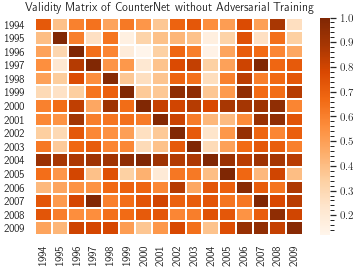

In [70]:
plot_heatmap(no_adv_res.to_numpy(), "Validity Matrix of CounterNet without Adversarial Training")
plt.savefig('assets/result/loan/no_adv_training.png', dpi=300)

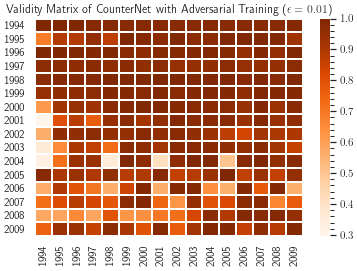

In [71]:
plot_heatmap(adv_eps_001.to_numpy(), "Validity Matrix of CounterNet with Adversarial Training ($\epsilon=0.01$)")
plt.savefig('assets/result/loan/adv_training_001.png', dpi=300)

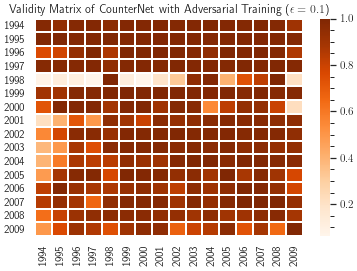

In [72]:
plot_heatmap(adv_eps_01.to_numpy(), "Validity Matrix of CounterNet with Adversarial Training ($\epsilon=0.1$)")
plt.savefig('assets/result/loan/adv_training_01.png', dpi=300)